In [1]:
import sys
import os
import re
sys.path.append('../scripts')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helpers as hp
import pickle as pkl
import itertools as it

from collections import OrderedDict, defaultdict

from sklearn.metrics import f1_score, precision_score, recall_score,\
                            average_precision_score, roc_auc_score,\
                            roc_curve, precision_recall_curve, confusion_matrix,\
                            accuracy_score, classification_report

from IPython.core.interactiveshell import InteractiveShell
from matplotlib import rcParams
from importlib import reload
from model_generator import deep_er_model_generator
pd.options.display.max_colwidth = 1000

rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'times new roman'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


# Load data 

In [2]:
reload(hp)

with open('../data/embeddings/glove-300.map', 'rb') as f:
    map = pkl.load(f)

data_dir = os.path.join('..','data')
source_dir = os.path.join(data_dir,'split','dblp-scholar')
data = hp.load_data(source_dir)

datasets = ['train_1', 'val_1', 'test_1', 'train_2', 'val_2', 'test_2']

for data_name in datasets:
    data[data_name] = data[data_name].fillna(0)

doc_freqs_1, doc_freqs_2 = hp.get_document_frequencies('../data/converted/dblp-scholar/', mapping=map)
nan_idx = map['word2idx']['NaN']

# Generate model

In [4]:
histories = dict(acc=list(), val_acc=list(), loss=list(), val_loss=list())
model, X_train, X_val, X_test, y_train, y_val, y_test = \
deep_er_model_generator(data,
                        embedding_file = '../data/embeddings/glove-300.matrix.npy',
                        text_columns = ['title', 'authors', 'venue'],
                        numeric_columns = ['year'],
                        text_nan_idx=nan_idx,
                        num_nan_val=0,
                        text_sim_metrics=['cosine'],
                        text_compositions=['average'],
                        numeric_sim_metrics=['min_max_ratio', 'scaled_inverse_lp', 'unscaled_inverse_lp'],
                        dense_nodes=[32, 16, 8],
                        document_frequencies=(doc_freqs_1, doc_freqs_2),
                        idf_smoothing=2,
                        make_isna=True)

Number of inputs to dense layer: 14


# Train model 

In [5]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, batch_size=16384,
                    validation_data=(X_val, y_val),
                    shuffle=True)

histories['acc'].extend(history.history['acc'])
histories['val_acc'].extend(history.history['val_acc'])
histories['loss'].extend(history.history['loss'])
histories['val_loss'].extend(history.history['val_loss'])

W0908 12:59:12.885916 13920 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0908 12:59:13.003286 13920 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 864075 samples, validate on 108010 samples
Epoch 1/10
864075/864075 [==============================] - 166s 192us/step - loss: 0.4036 - acc: 0.8688 - val_loss: 0.1359 - val_acc: 0.9902
Epoch 2/10
864075/864075 [==============================] - 131s 151us/step - loss: 0.0908 - acc: 0.9901 - val_loss: 0.0717 - val_acc: 0.9902
Epoch 3/10
864075/864075 [==============================] - 128s 148us/step - loss: 0.0664 - acc: 0.9901 - val_loss: 0.0595 - val_acc: 0.9902
Epoch 4/10
864075/864075 [==============================] - 128s 148us/step - loss: 0.0539 - acc: 0.9901 - val_loss: 0.0472 - val_acc: 0.9902
Epoch 5/10
864075/864075 [==============================] - 126s 146us/step - loss: 0.0417 - acc: 0.9901 - val_loss: 0.0354 - val_acc: 0.9902
Epoch 6/10
864075/864075 [==============================] - 127s 147us/step - loss: 0.0315 - acc: 0.9901 - val_loss: 0.0270 - val_acc: 0.9902
Epoch 7/10
864075/864075 [==============================] - 127s 147us/step - loss: 0.0246 - acc

# Learning curves

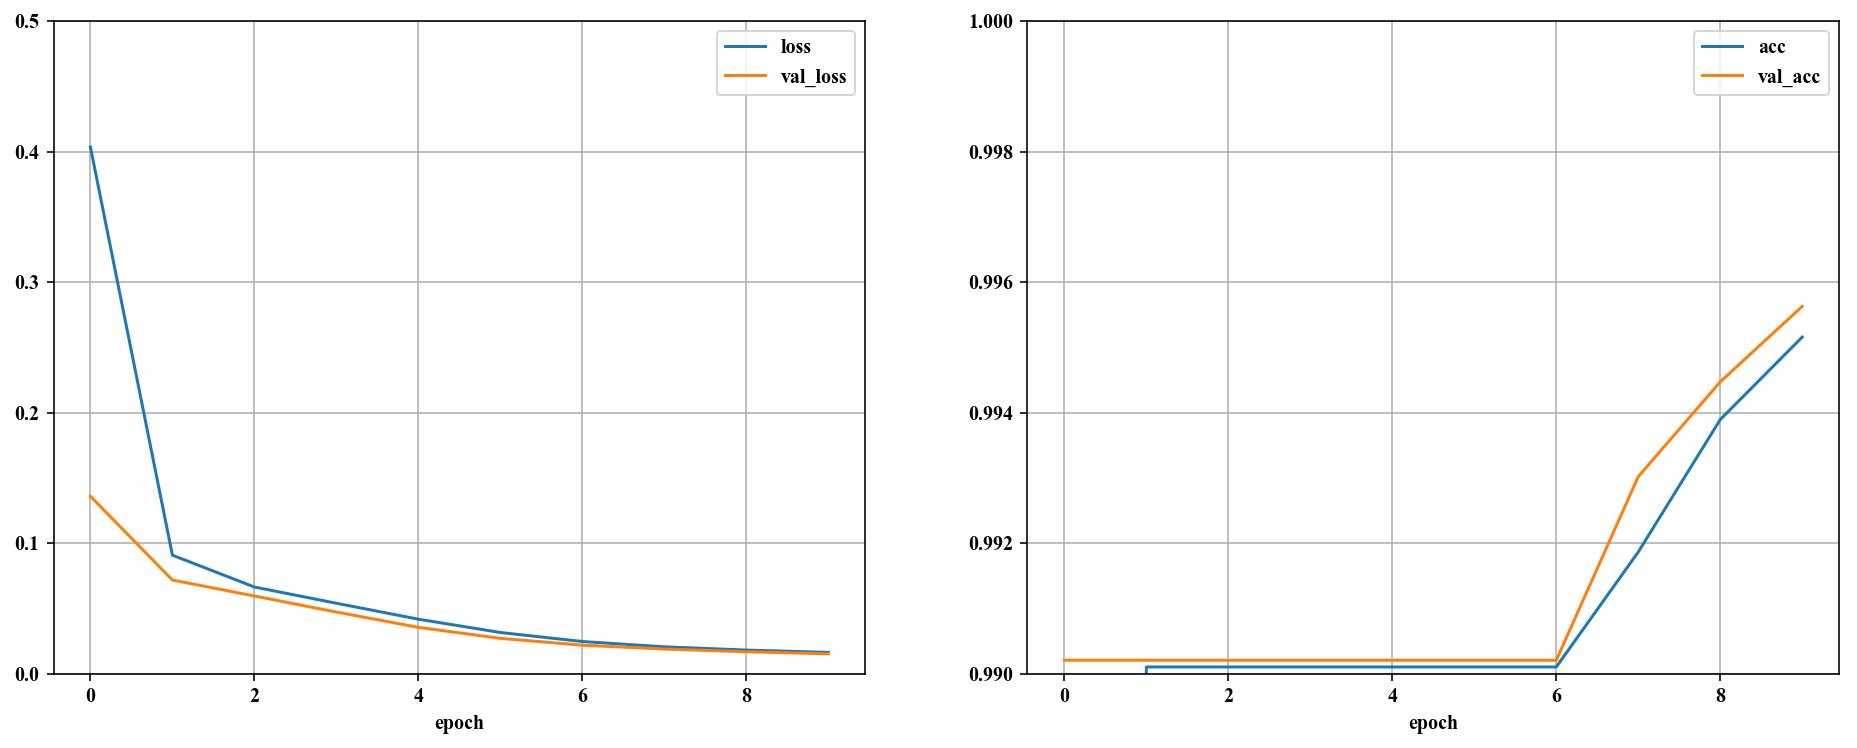

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))
axes[0].plot(histories['loss'], label='loss')
axes[0].plot(histories['val_loss'], label='val_loss')
axes[0].set_ylim(0, 0.5)
axes[1].plot(histories['acc'], label='acc')
axes[1].plot(histories['val_acc'], label='val_acc')
axes[1].set_ylim(.99, 1)

for ax in axes:
    ax.legend()
    ax.grid(True)
    ax.set(xlabel='epoch')

# Evaluate model 

In [7]:
y_val_pred = model.predict(X_val, batch_size=8192)[:,1]
y_val_ = data['val_y'].values.squeeze()
print(classification_report(y_val_, y_val_pred >= 0.5))
print(confusion_matrix(y_val_, y_val_pred >= 0.5))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    106952
           1       0.97      0.57      0.72      1058

   micro avg       1.00      1.00      1.00    108010
   macro avg       0.98      0.78      0.86    108010
weighted avg       1.00      1.00      1.00    108010

[[106936     16]
 [   456    602]]


In [ ]:
mapping = map.copy()
bool_mask = (y_val_ == 1) & ~(y_val_pred >= 0.5)
columns = ['title', 'authors', 'venue']
df_examine = hp.examine_data(data['val_1'], data['val_2'], columns, bool_mask, mapping)
df_examine.sample(5)

# Save model and histories 

In [ ]:
pd.DataFrame(histories).to_csv('../data/histories/dblp-scholar.csv', index=False)
model.save_weights('../data/models/dblp-scholar-base-1-num-null')

# Test model 

In [ ]:
model.load_weights('../data/models/dblp-scholar-base-1-num-null')
y_test_pred = model.predict(X_test, batch_size=8192)[:,1]
y_test_ = data['test_y'].values.squeeze()
print(classification_report(y_test_, y_test_pred >= 0.5, digits=5))
print(confusion_matrix(y_test_, y_test_pred >= 0.5))

In [ ]:
set(y_test_) - set(y_test_pred)

In [ ]:
from collections import Counter
Counter(y_test_pred)

In [ ]:
Counter(y_test_)

In [ ]:
y_train